In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import t3nsor as t3

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from argparse import Namespace
import tqdm.notebook

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

In [2]:
history_path = "../DropEdge/runs/run_history-dataset_citeseer-type_mutigcn"
history_df = pd.read_csv(history_path)
history_df.head()

,Unnamed: 0,loss_train,acc_train,loss_val,acc_val,cur_lr,s_time,t_time,v_time
0,0,2.163904,0.174945,1.797720,0.176,0.009,0.004003,0.517994,0.085767
1,1,2.154949,0.169978,1.787375,0.178,0.009,0.004626,0.501287,0.088756
2,2,2.145338,0.164459,1.785773,0.182,0.009,0.004850,0.481117,0.093227
3,3,2.101135,0.178808,1.785245,0.180,0.009,0.004834,0.483460,0.085542
4,4,2.099145,0.179360,1.786212,0.180,0.009,0.004530,0.491336,0.084258


Text(0, 0.5, 'accuracy')

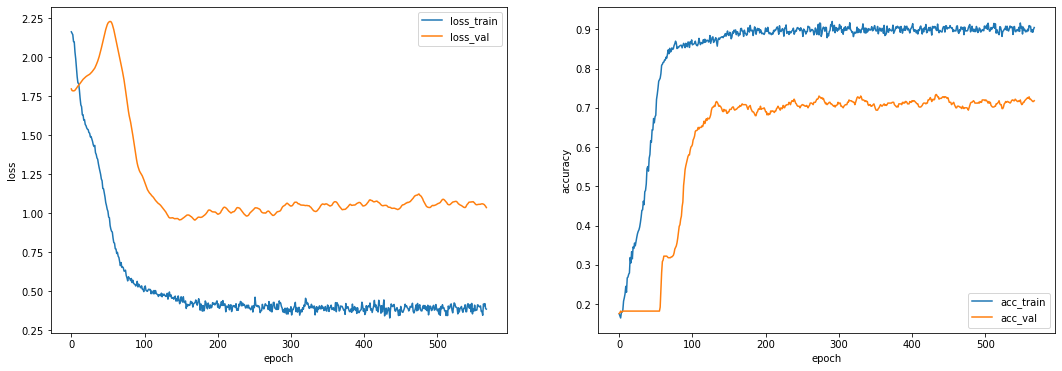

In [3]:
fig,axs = plt.subplots(1, 2, figsize=(18, 6))

history_df[['loss_train', 'loss_val']].plot(ax=axs[0])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

history_df[['acc_train', 'acc_val']].plot(ax=axs[1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [5]:
model_path = "../DropEdge/tmpmodel/tmp-0205-124314-elA.pt"
args_path = "../DropEdge/tmpmodel/args.json"

with open(args_path, 'r') as f:
    args = json.loads(f.read())
    print("args: ", args)
    args = Namespace(**args)

args.datapath = '../DropEdge/' + args.datapath
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

sampler = Sampler(args.dataset, args.datapath, args.task_type)
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args.cuda)
nfeat = sampler.nfeat
nclass = sampler.nclass

base_model = GCNModel(nfeat=nfeat,
                      nhid=args.hidden,
                      nclass=nclass,
                      nhidlayer=args.nhiddenlayer,
                      dropout=args.dropout,
                      baseblock=args.type,
                      inputlayer=args.inputlayer,
                      outputlayer=args.outputlayer,
                      nbaselayer=args.nbaseblocklayer,
                      activation=F.relu,
                      withbn=args.withbn,
                      withloop=args.withloop,
                      aggrmethod=args.aggrmethod,
                      mixmode=args.mixmode)

if device == torch.device('cuda'):
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
base_model.load_state_dict(state_dict)
base_model.to(device)

args:  {'no_cuda': False, 'fastmode': False, 'seed': 42, 'epochs': 1000, 'lr': 0.009, 'lradjust': False, 'weight_decay': 0.001, 'mixmode': False, 'warm_start': '', 'debug': True, 'dataset': 'citeseer', 'datapath': 'data//', 'early_stopping': 400, 'no_tensorboard': False, 'type': 'mutigcn', 'inputlayer': 'gcn', 'outputlayer': 'gcn', 'hidden': 256, 'dropout': 0.8, 'withbn': True, 'withloop': True, 'nhiddenlayer': 1, 'normalization': 'BingGeNormAdj', 'sampling_percent': 0.05, 'nbaseblocklayer': 3, 'aggrmethod': 'nores', 'task_type': 'full', 'cuda': False}
Load full supervised task.


/Users/ms/Learningspace/svd4gcn/DropEdge/src/normalization.py:110: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


GCNModel(
  (ingc): GraphConvolutionBS(
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outgc): GraphConvolutionBS(
    (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
  )
)

In [115]:
class GraphConvolutionTTLinear(Module):
    def __init__(self, orig_layer, tt_rank, d=3, auto_shape_criterion='entropy', auto_shape_mode='ascending'):
        super(GraphConvolutionTTLinear, self).__init__()
        self.tt_rank = tt_rank
        
#         self.tt_linear_layer = t3.layers.TTLinear(
#             orig_layer.in_features,
#             orig_layer.out_features,
#             forward_mode='auto',
#             bias=False,
#             tt_rank=self.tt_rank
#         )
        in_quantization = t3.utils.auto_shape(
            orig_layer.in_features, d=d, criterion=auto_shape_criterion, mode=auto_shape_mode)
        out_quantization = t3.utils.auto_shape(
            orig_layer.out_features, d=d, criterion=auto_shape_criterion, mode=auto_shape_mode)

        self.tt_raw_shape = [in_quantization, out_quantization]
            
        self.tt_weight = t3.decompositions.to_tt_matrix(
            orig_layer.weight,
            self.tt_raw_shape,
            self.tt_rank
        )
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, _input, adj):
        support = t3.naive_dense_tt_matmul(_input, self.tt_weight)
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.tt_rank) + ')'

In [116]:
def test(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args.normalization,
    cuda= device == torch.device('cuda')
)

In [117]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
    new_model.ingc = GraphConvolutionTTLinear(new_model.ingc, r)
    new_model.to(device)
    return new_model

In [118]:
model = make_new_model(base_model, 3)
loss_test, acc_test = test(model, test_adj, test_fea)
print(loss_test, acc_test)
model

3.1692609786987305 0.231


GCNModel(
  (ingc): GraphConvolutionTTLinear (3703 -> 256, 3)
  (outgc): GraphConvolutionBS(
    (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): GraphConvolutionBS(
            (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
  )
)

In [119]:
base_loss_test, base_acc_test = test(base_model, test_adj, test_fea)
print(f"Loss test on base_model = {base_loss_test}\nAcc test of base_model = {base_acc_test}")

Loss test on base_model = 0.7972075343132019
Acc test of base_model = 0.756


In [120]:
experiments = {
    'tt_rank': [],
    'loss': [],
    'acc': []
}

for tt_rank in tqdm.notebook.tqdm(range(1, 10)):
    model = make_new_model(base_model, tt_rank)
    loss_test, acc_test = test(model, test_adj, test_fea)
    experiments['tt_rank'].append(tt_rank)
    experiments['loss'].append(loss_test)
    experiments['acc'].append(acc_test)
    del model

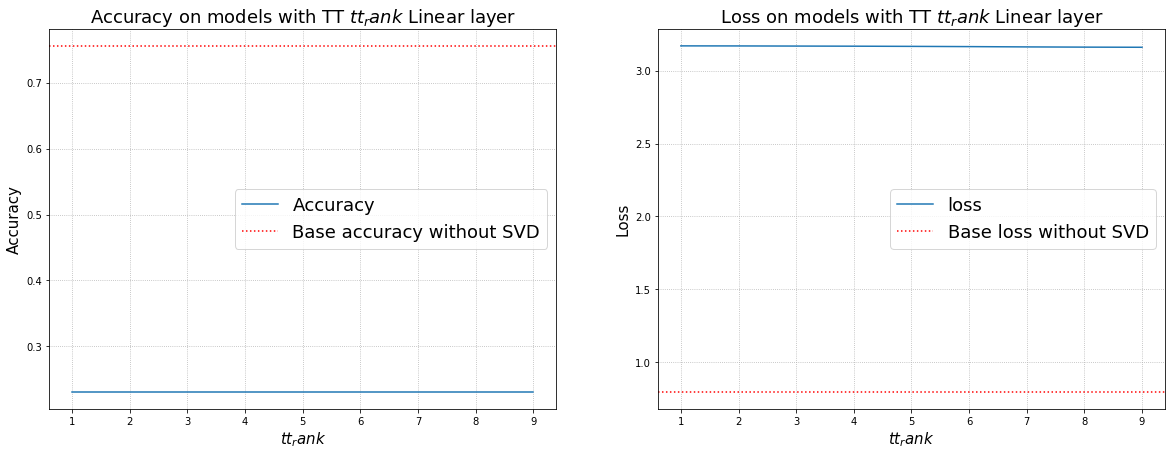

In [121]:
fig,axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

axs[0].plot(experiments['tt_rank'], experiments['acc'], label='Accuracy')
axs[0].axhline(y=base_acc_test, color='r', linestyle=':', label="Base accuracy without SVD")
axs[0].legend(fontsize=18)
axs[0].set_title("Accuracy on models with TT $tt_rank$ Linear layer", fontsize=18)
axs[0].set_ylabel("Accuracy", fontsize=15)
axs[0].set_xlabel("$tt_rank$", fontsize=15)
axs[0].grid(ls=":")

axs[1].plot(experiments['tt_rank'], experiments['loss'], label='loss')
axs[1].axhline(y=base_loss_test, color='r', linestyle=':', label="Base loss without SVD")
axs[1].legend(fontsize=18)
axs[1].set_title("Loss on models with TT $tt_rank$ Linear layer", fontsize=18)
axs[1].set_ylabel("Loss", fontsize=15)
axs[1].set_xlabel("$tt_rank$", fontsize=15)
axs[1].grid(ls=":")